In [1]:
#importing libraries
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor,Normalize,Compose,Grayscale
from torchvision.datasets import ImageFolder
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
%matplotlib inline

In [2]:
#tranforms for the images
transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,)),Grayscale()])

In [3]:
#Loading the images
train_ds=ImageFolder("~/Coding/python files/Deep Learning/Image classification/mnist_png/training",transform)

In [4]:
#Test image
image,label=train_ds[9999]


torch.Size([1, 28, 28])


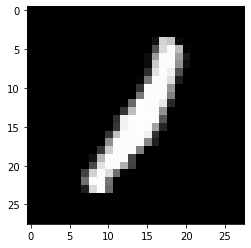

In [5]:
plt.imshow(image.permute(1,2,0),cmap='gray')
print(image.shape)

In [6]:
batch_size=100

In [7]:
#Wrapping data in dataloader
train_dl=DataLoader(train_ds,batch_size,shuffle=True)

In [8]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

torch.Size([100, 1, 28, 28])
tensor([0, 1, 8, 6, 9, 5, 6, 3, 8, 9, 7, 1, 9, 9, 7, 0, 0, 0, 4, 5, 6, 6, 9, 7,
        9, 1, 4, 3, 1, 9, 3, 6, 2, 9, 6, 7, 3, 8, 8, 8, 9, 2, 4, 0, 9, 0, 9, 9,
        2, 6, 0, 2, 2, 8, 7, 0, 2, 7, 4, 4, 9, 4, 6, 6, 5, 9, 3, 4, 8, 0, 8, 6,
        1, 2, 2, 3, 7, 8, 2, 4, 4, 1, 1, 3, 4, 9, 3, 9, 5, 0, 1, 8, 4, 6, 4, 5,
        6, 7, 7, 3])


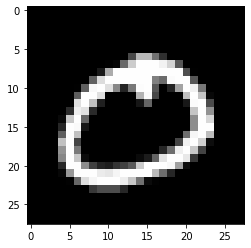

In [9]:
for img_batch,label_batch in train_dl:
    print(img_batch.shape)
    plt.imshow(denorm(img_batch[0][0]),cmap='gray')
    print(label_batch)
    break

In [10]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

In [11]:
image_size=28*28
hidden_size=256

In [12]:
#Discriminator model
D= nn.Sequential(
    nn.Linear(image_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,1),
    nn.Sigmoid()
)

In [13]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [14]:
latent_size=74

In [15]:
#Generator model
G=nn.Sequential(
    nn.Linear(latent_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,image_size),
    nn.Tanh()

)

In [16]:
#Test data into generator model
gen = G(torch.randn(2,latent_size))

In [17]:
gen.shape

torch.Size([2, 784])

In [18]:
gen_imgs = gen.reshape(-1,28,28) #reshaping to make an image
gen_imgs= gen_imgs.detach() #calling detach to remove the 'grad' requirement

In [19]:
gen_imgs.shape

torch.Size([2, 28, 28])

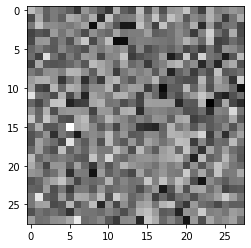

In [20]:
plt.imshow(gen_imgs[0],cmap='gray')

In [21]:
G.to(device)

Sequential(
  (0): Linear(in_features=74, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [22]:
#using Binary Cross Entropy as loss for Discriminator model
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(),lr=0.0002)

In [23]:
#Helper functions for training Discriminator

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [24]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [25]:
#Helper function for Generator training.
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [26]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

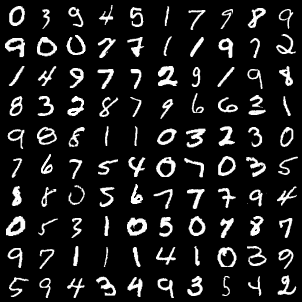

In [27]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in train_dl:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


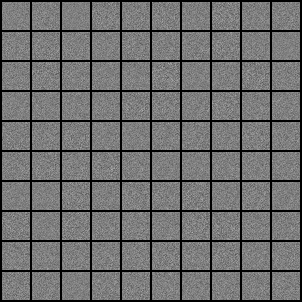

In [28]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [29]:
%%time

num_epochs = 300
total_step = len(train_dl)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_dl):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images and model parameters
    save_fake_images(epoch+1)
    torch.save(G.state_dict(), 'G.ckpt')
    torch.save(D.state_dict(), 'D.ckpt')

Epoch [0/300], Step [200/600], d_loss: 0.0529, g_loss: 3.8430, D(x): 0.99, D(G(z)): 0.04
Epoch [0/300], Step [400/600], d_loss: 0.1177, g_loss: 6.0242, D(x): 0.95, D(G(z)): 0.04
Epoch [0/300], Step [600/600], d_loss: 0.1085, g_loss: 5.0404, D(x): 0.95, D(G(z)): 0.05
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.1076, g_loss: 4.6808, D(x): 0.98, D(G(z)): 0.08
Epoch [1/300], Step [400/600], d_loss: 0.1601, g_loss: 4.8337, D(x): 0.97, D(G(z)): 0.08
Epoch [1/300], Step [600/600], d_loss: 0.9932, g_loss: 2.6630, D(x): 0.83, D(G(z)): 0.43
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.2011, g_loss: 4.6274, D(x): 0.93, D(G(z)): 0.08
Epoch [2/300], Step [400/600], d_loss: 0.1755, g_loss: 3.4677, D(x): 0.95, D(G(z)): 0.08
Epoch [2/300], Step [600/600], d_loss: 1.6336, g_loss: 2.4801, D(x): 0.58, D(G(z)): 0.31
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.2244, g_loss: 3.7445, D(x): 0.91, D(G(z)): 0.09
Epoch [3/300], Step [400/6

In [30]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

In [40]:
gen = G(torch.randn(1,latent_size).to(device))

In [41]:
gen[0]

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9979, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -0.9974, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9998, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.00

In [42]:
gen_img = gen.reshape(-1,28,28).detach()
gen_img.shape

torch.Size([1, 28, 28])

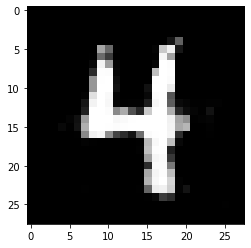

In [43]:
plt.imshow(gen_img.cpu().permute(1,2,0),cmap='gray') #generates random number

In [44]:
#stitching the 300 fake images together to make a video showing the progress of training
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/home/rishabh/Coding/python files/Deep Learning/GANs/gans_training.avi

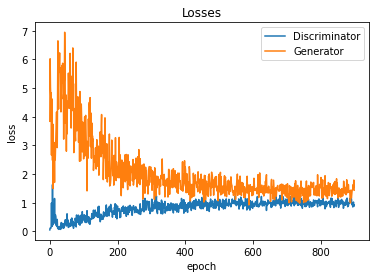

In [45]:
#comparing discriminator and generator losses
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

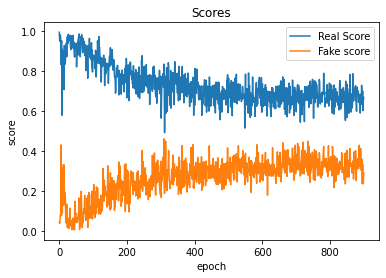

In [46]:
#score comparison
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');